# MDR evolution stochastic model
Chris Ford used a <strong>Stochastic compartmental model</strong> to contextualise his fluctuation assay findings in the 2012 Nature Genetics paper: 
http://www.nature.com/ng/journal/v45/n7/full/ng.2656.html

In [6]:
#Set up kernel
from scipy import stats as ss
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import utils as sku
#import beeswarm as bs
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
import tqdm

mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['font.family']='Arial'

%matplotlib inline

## The model
It's a compartmental model, with a Poisson-driven generation of mutants.

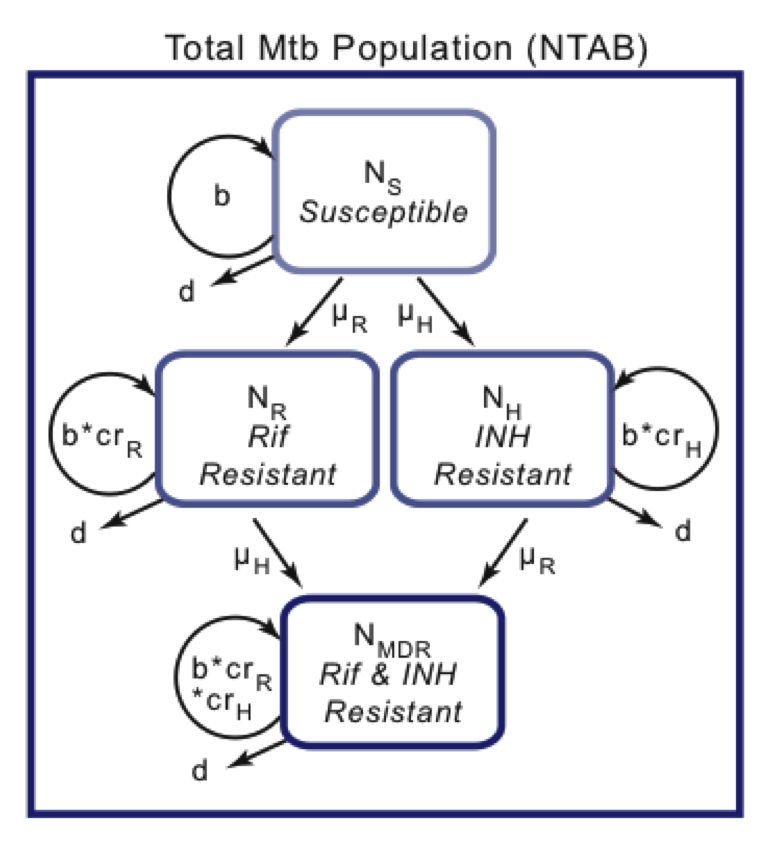

In [3]:
from IPython.display import Image
fig = Image(filename=('150811_chris_model.png'),retina=True)
fig

### Equations:
<strong>Compartments</strong>

$N_S(t)=[N_S(t-1)\times(b-d)]-m_{RS}-m_{SH}$

$N_R(t)=[N_R(t-1)\times(b\times(1-cr_R)-d)]+m_{RS}-m_{RH}$

$N_H(t)=[N_H(t-1)\times(b\times(1-cr_H)-d)]+m_{SH}-m_{HR}$

$N_{MDR}(t)=[N_{MDR}(t-1)\times(b\times(1-cr_{MDR})-d)]+m_{HR}+m_{RH}$

<strong>Mutation simulations</strong>

$m_{RS}\sim Poisson(\mu_R*N_S(t-1))$

$m_{SH}\sim Poisson(\mu_H*N_S(t-1))$

$m_{RH}\sim Poisson(\mu_H*N_R(t-1))$

$m_{HR}\sim Poisson(\mu_R*N_H(t-1))$

<strong>Dual resistance probability</strong>

$P_{dual} = \beta_{12}\times\beta N_F\times(\frac{\lambda}{\lambda-\mu})\times(\frac{\lambda_1}{\lambda_1-\mu_1})\times(\frac{\phi}{1-\phi})$

### Parameters
#### Mutation rates:
$\mu_H=\beta_{CDC}=8.43\times 10^{-8}$ (CDC1551, Lineage 4)

$\mu_R=\beta_{CDC-12}=2.42\times 10^{-9}$ (CDC1551, Lineage 4)

$\mu_H=\beta_W=2.32\times 10^{-7}$ (HN878, Lineage 2)

$\mu_R=\beta_{W-12}=1.94\times 10^{-8}$ (HN878, Lineage 2)

#### Demographic parameters:

growth rate: $b=0.2$

death rate: $d=0.15$

fitness cost (as per original paper): $cr_R=cr_H=0$

<em>note however that Chris also simulates a number of different fitness costs for MDR strains with the outcomes giving rise to variable $P_{dual}$ trajectories.</em>

#### $P_{dual}$ parameters

$\lambda=\lambda_1=0.4$

$\mu=\mu_1=0.15$

$\phi=0.8$

### Code them in

In [4]:
#Define variables
mu_H_CDC = 8.43e-8
mu_R_CDC = 2.42e-9
mu_H = mu_H_W = 2.32e-7
mu_R = mu_R_W = 1.94e-8
b = 0.2
cR = cH = 0
d = 0.15
lam = lam1 = 0.4
mu = mu1 = 0.15
phi = 0.8

#Define key functions
NS = lambda ns: ns*(b-d)-ss.poisson(ns*mu_H).rvs()-ss.poisson(ns*mu_R).rvs()
NR = lambda ns,nr,cR: nr*(b*(1-cR)-d)+ss.poisson(ns*mu_R).rvs()-ss.poisson((nr+0.000001)*mu_H).rvs()
NH = lambda ns,nh,cH: nh*(b*(1-cH)-d)+ss.poisson(ns*mu_H).rvs()-ss.poisson((nh+0.000001)*mu_R).rvs()
NHR = lambda nr,nh,nhr,cR,cH: nhr*(b*(1-(cR*cH))-d)+ss.poisson((nh+0.000001)*mu_R).rvs()+ss.poisson((nr+0.000001)*mu_H).rvs()

#Function to run simulation:
def DR_model(N0=[10.,0.,0.,0.], b=0.2, d=0.15, cR=0, cH=0, mu_H=2.32e-7, mu_R=1.94e-8, generations=500, step=10):
    """Simulate the generation of MDR in TB patients.
    
    INPUTS:
    -------
    N0: 1d-array, starting parameters
    b: float, birth rate
    d: float, death rate
    cR: float, cost of RIF resistance
    cH: float, cost of INH resistance
    mu_H: float, INH frequency of resistance
    mu_R: float, RIF frequency of resistance
    generations: int, number of generations for the simlation
    step: int, save result every X steps
    
    OUTPUT:
    -------
    2d-array, 4*m (m = generation/step+1)
    
    NOTES:
    ------
    Based on Chris Ford's thesis. This will perform a 
    single run of the simulation.
    
    Requires scipy.stats as ss and numpy as np
    
    """
    #+0.000001 is a fudge to avoid ss.poisson to crap out by asking it to
    #generate random numbers with a lambda of 0.
    
    _NS = lambda ns: ns*(b-d)-ss.poisson(ns*mu_H).rvs()-ss.poisson(ns*mu_R).rvs()
    _NR = lambda ns,nr,cR: nr*(b*(1-cR)-d)+ss.poisson(ns*mu_R).rvs()-ss.poisson((nr+0.000001)*mu_H).rvs()
    _NH = lambda ns,nh,cH: nh*(b*(1-cH)-d)+ss.poisson(ns*mu_H).rvs()-ss.poisson((nh+0.000001)*mu_R).rvs()
    _NHR = lambda nr,nh,nhr,cR,cH: nhr*(b*(1-(cR*cH))-d)+ss.poisson((nh+0.000001)*mu_R).rvs()+ss.poisson((nr+0.000001)*mu_H).rvs()
    
    _currentP = N0
    _result = [N0]
    
    _to_keep = range(9,generations,step)
    
    for i in range(1,generations):
        _lastP = _currentP #move to the next
        _currentP = [_lastP[0]+_NS(_lastP[0]),
                     _lastP[1]+_NR(_lastP[0],_lastP[1],cR),
                     _lastP[2]+_NH(_lastP[0],_lastP[2],cH),
                     _lastP[3]+_NHR(_lastP[1],_lastP[2],_lastP[3],cR,cH)]
        
        if i in _to_keep:
            _result.append(_currentP)
    
    return _result

Let's try it out.

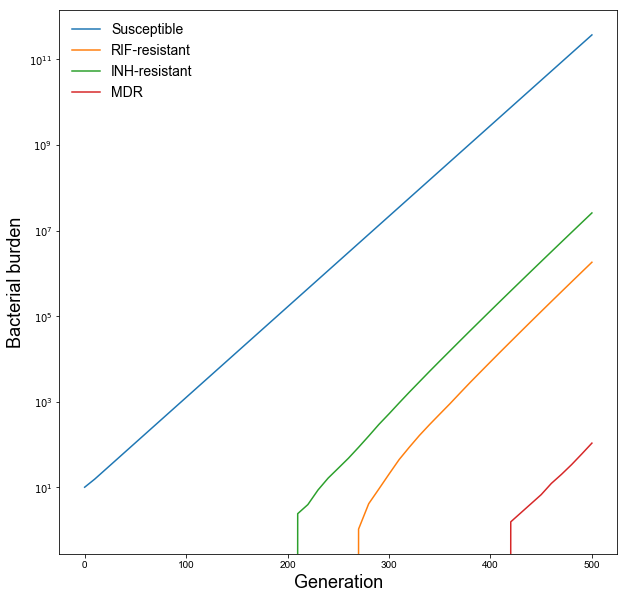

In [8]:
simple_simulation = np.array(DR_model(), dtype=float)

plt.figure('MDR_simulation', figsize=(10,10))
plt.plot(simple_simulation)
plt.yscale('log')
plt.xticks(range(0,51,10), [0,100,200,300,400,500])
plt.xlabel('Generation', size=18)
plt.ylabel('Bacterial burden', size=18)
plt.legend(['Susceptible', 'RIF-resistant', 'INH-resistant', 'MDR'],
           loc=2,fontsize=14,frameon=False)

Looks good!

Now, for the fun of it, let's have a look at how the simulated populations behave in the presence of fitness cost. Let's make two mutants, one with minor cost: 0.01 and one with a considerable cost: 0.1 both occuring with the same frequency.

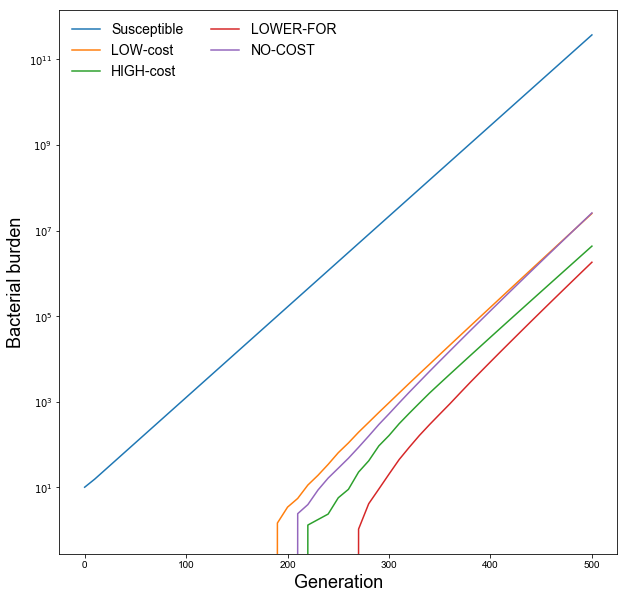

In [9]:
fitness_simulation = np.array(DR_model(N0=[10.,0.,0.,0.], 
                                      b=0.2, d=0.15, 
                                      cR=0.01, cH=0.1, 
                                      mu_H=2.32e-7, mu_R=2.32e-7, 
                                      generations=500, step=10), dtype=float)

plt.figure('FITNESS_simulation', figsize=(10,10))
plt.plot(fitness_simulation[:,:3])
plt.plot(simple_simulation[:,[1,2]])
plt.yscale('log')
plt.xticks(range(0,51,10), [0,100,200,300,400,500])
plt.xlabel('Generation', size=18)
plt.ylabel('Bacterial burden', size=18)
plt.legend(['Susceptible', 'LOW-cost', 'HIGH-cost', 'LOWER-FOR', 'NO-COST'],
           loc=2, ncol=2, fontsize=14, frameon=False)

Emergence is stochastic, therefore a no, low or a high cost mutations that share the same $\mu$ are equally as likely to emerge, however, their frequency within the population will then be determined by their fitness. So, let's run 100 simulations of each type of simulation and see the distributions of the time of emergence, and population size at the time of emergence, as well as frequency at the end.

In [4]:
SIMULATION_RESULTS = {}

for click in tqdm.tqdm(np.arange(0,400,4)):
    _fitness_sim = DR_model(N0=[10.,0.,0.,0.], b=0.2, d=0.15, 
                            cR=0.01, cH=0.1, mu_H=2.32e-7, mu_R=2.32e-7, 
                            generations=300, step=3)
    _simple_sim = DR_model(generations=300, step=3)
    
    _fitness_sim = np.array(_fitness_sim)
    _simple_sim = np.array(_simple_sim)
    
    SIMULATION_RESULTS[click] ={'TYPE': 'NO_COST', 
                                'TIME_EMERGENCE': min(np.where(_simple_sim[:,2]>0)[0]), 
                                'POP_SIZE_EMERGENCE': _simple_sim[min(np.where(_simple_sim[:,2]>0)[0]),:].sum(), 
                                'FINAL_PROPORTION': _simple_sim[-1,2]/_simple_sim[-1,:].sum()}
    click+=1
    
    SIMULATION_RESULTS[click] ={'TYPE': 'LOW_COST', 
                                'TIME_EMERGENCE': min(np.where(_fitness_sim[:,1]>0)[0]), 
                                'POP_SIZE_EMERGENCE': _fitness_sim[min(np.where(_fitness_sim[:,1]>0)[0]),:].sum(), 
                                'FINAL_PROPORTION': _fitness_sim[-1,1]/_fitness_sim[-1,:].sum()}
    click+=1
    
    SIMULATION_RESULTS[click] ={'TYPE': 'HIGH_COST', 
                                'TIME_EMERGENCE': min(np.where(_fitness_sim[:,2]>0)[0]), 
                                'POP_SIZE_EMERGENCE': _fitness_sim[min(np.where(_fitness_sim[:,2]>0)[0]),:].sum(), 
                                'FINAL_PROPORTION': _fitness_sim[-1,2]/_fitness_sim[-1,:].sum()}
    click+=1
    
    SIMULATION_RESULTS[click] ={'TYPE': 'LOW_FOR', 
                                'TIME_EMERGENCE': min(np.where(_simple_sim[:,1]>0)[0]), 
                                'POP_SIZE_EMERGENCE': _simple_sim[min(np.where(_simple_sim[:,1]>0)[0]),:].sum(), 
                                'FINAL_PROPORTION': _simple_sim[-1,1]/_simple_sim[-1,:].sum()}

100%|██████████| 100/100 [10:24<00:00,  6.16s/it]


In [5]:
SIM_df = pd.DataFrame(SIMULATION_RESULTS).T
SIM_df.head()

,FINAL_PROPORTION,POP_SIZE_EMERGENCE,TIME_EMERGENCE,TYPE
0,2.25459e-05,210192,66,NO_COST
1,2.86266e-05,243314,67,LOW_COST
2,1.02808e-05,377461,70,HIGH_COST
3,1.12218e-06,2.92983e+06,84,LOW_FOR
4,4.45081e-05,42012.7,55,NO_COST


([<matplotlib.axis.XTick at 0x117434dd0>,
 <a list of 4 Text xticklabel objects>)

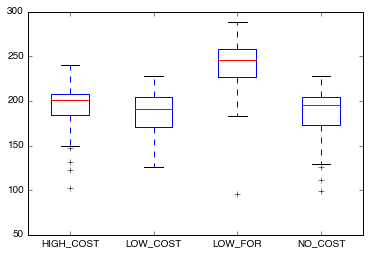

In [29]:
plt.boxplot([list(SIM_df.TIME_EMERGENCE[SIM_df.TYPE==x]*3) for x in np.unique(SIM_df.TYPE)])
plt.xticks([1,2,3,4], np.unique(SIM_df.TYPE))
#plt.yscale('log')

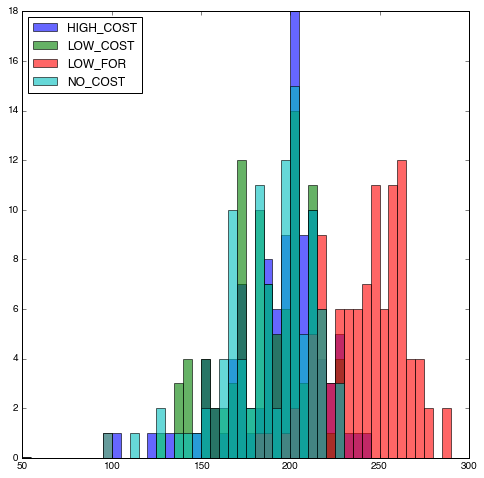

In [30]:
plt.figure(figsize=(8,8))
for x in np.unique(SIM_df.TYPE):
    plt.hist(list(SIM_df.TIME_EMERGENCE[SIM_df.TYPE==x]*3), bins=np.arange(50, 300, 5), label=x, alpha=0.6)
plt.legend(loc=2)

In [27]:
for x in np.unique(SIM_df.TYPE):
    print('{0}: generation {1:.0f}'.format(x,SIM_df.TIME_EMERGENCE[SIM_df.TYPE==x].mean()*3))

HIGH_COST: generation 194
LOW_COST: generation 188
LOW_FOR: generation 241
NO_COST: generation 188


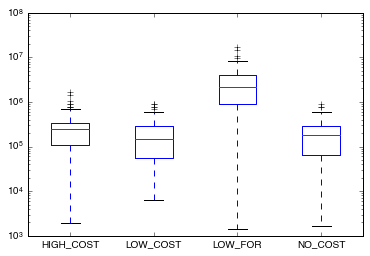

In [9]:
plt.boxplot([list(SIM_df.POP_SIZE_EMERGENCE[SIM_df.TYPE==x]) for x in np.unique(SIM_df.TYPE)])
plt.xticks([1,2,3,4], np.unique(SIM_df.TYPE))
plt.yscale('log')

([<matplotlib.axis.XTick at 0x113a24850>,
 <a list of 6 Text xticklabel objects>)

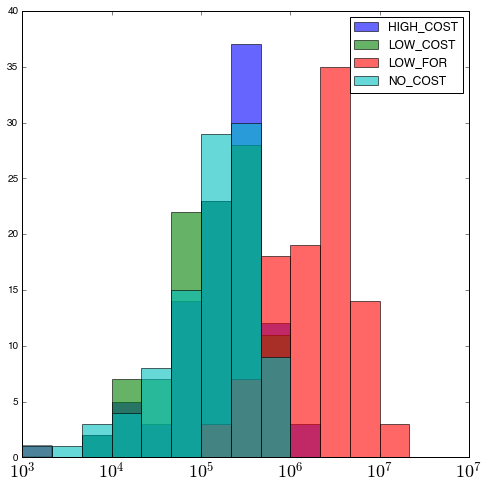

In [10]:
plt.figure(figsize=(8,8))
for x in np.unique(SIM_df.TYPE):
    plt.hist(np.log10(list(SIM_df.POP_SIZE_EMERGENCE[SIM_df.TYPE==x])), bins=np.arange(3, 8, .3333), label=x, alpha=0.6)
plt.legend()
plt.xticks([3,4,5,6,7,8],[r'$10^{3}$',r'$10^{4}$',r'$10^{5}$',r'$10^{6}$',r'$10^{7}$',r'$10^{7}$'],size=18)

In [11]:
for x in np.unique(SIM_df.TYPE):
    print('{0} emergence at population size: {1:.2e}'.format(x,SIM_df.POP_SIZE_EMERGENCE[SIM_df.TYPE==x].mean()))

HIGH_COST emergence at population size: 2.89e+05
LOW_COST emergence at population size: 2.15e+05
LOW_FOR emergence at population size: 2.91e+06
NO_COST emergence at population size: 2.08e+05


In [12]:
ss.mannwhitneyu(np.log10(list(SIM_df.POP_SIZE_EMERGENCE[SIM_df.TYPE=='HIGH_COST'])),
                np.log10(list(SIM_df.POP_SIZE_EMERGENCE[SIM_df.TYPE=='NO_COST'])))

MannwhitneyuResult(statistic=4218.0, pvalue=0.028096330596054563)

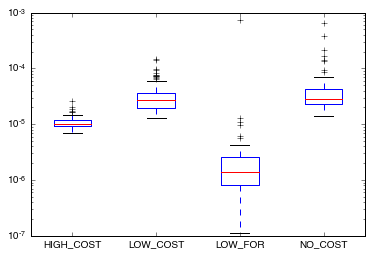

In [13]:
plt.boxplot([list(SIM_df.FINAL_PROPORTION[SIM_df.TYPE==x]) for x in np.unique(SIM_df.TYPE)])
plt.xticks([1,2,3,4], np.unique(SIM_df.TYPE))
plt.yscale('log')

([<matplotlib.axis.XTick at 0x113f4a750>,
 <a list of 5 Text xticklabel objects>)

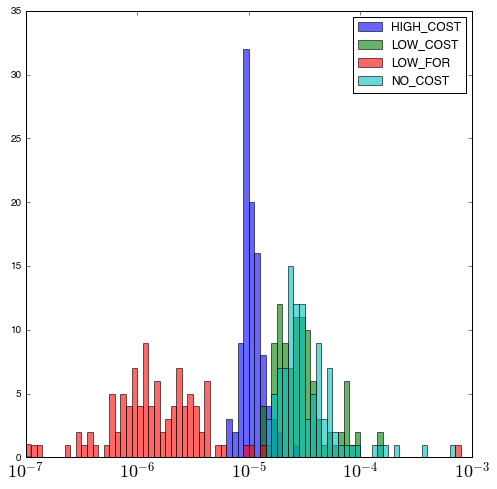

In [15]:
plt.figure(figsize=(8,8))
for x in np.unique(SIM_df.TYPE):
    plt.hist(np.log10(list(SIM_df.FINAL_PROPORTION[SIM_df.TYPE==x])), bins=np.arange(-7, -3.05, .05), label=x, alpha=0.6)
plt.legend()
plt.xticks([-7,-6,-5,-4,-3],[r'$10^{-7}$', r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$'],size=18)

In [16]:
ss.mannwhitneyu(np.log10(list(SIM_df.FINAL_PROPORTION[SIM_df.TYPE=='HIGH_COST'])),
                np.log10(list(SIM_df.FINAL_PROPORTION[SIM_df.TYPE=='NO_COST'])))

MannwhitneyuResult(statistic=85.0, pvalue=1.6120815142088698e-33)

In [18]:
ss.mannwhitneyu(np.log10(list(SIM_df.FINAL_PROPORTION[SIM_df.TYPE=='LOW_COST'])),
                np.log10(list(SIM_df.FINAL_PROPORTION[SIM_df.TYPE=='NO_COST'])))

MannwhitneyuResult(statistic=4454.0, pvalue=0.091287458067336957)

In [17]:
for x in np.unique(SIM_df.TYPE):
    print('{0} proportion of final population: {1:.2e}'.format(x,SIM_df.FINAL_PROPORTION[SIM_df.TYPE==x].mean()))

HIGH_COST proportion of final population: 1.10e-05
LOW_COST proportion of final population: 3.47e-05
LOW_FOR proportion of final population: 9.28e-06
NO_COST proportion of final population: 4.74e-05


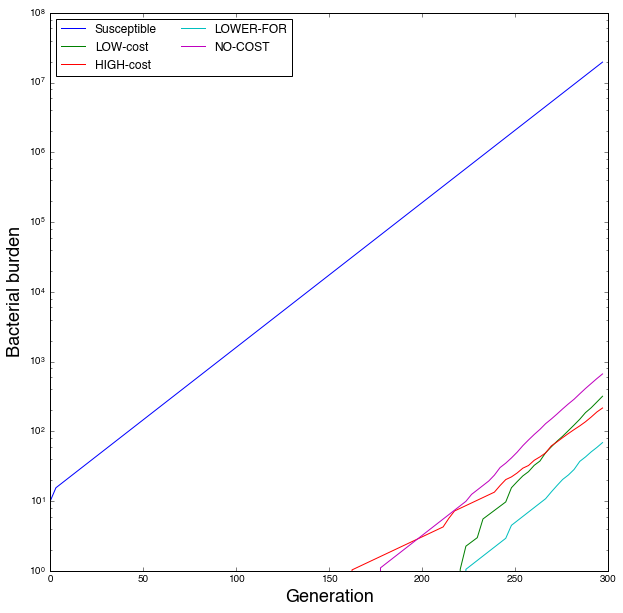

In [40]:
plt.figure('FITNESS_simulation', figsize=(10,10))
plt.plot(_fitness_sim[:,:3])
plt.plot(_simple_sim[:,[1,2]])
plt.yscale('log')
plt.xticks(np.linspace(0,98,7), np.arange(0,310,50))
plt.xlim(0,98)
plt.xlabel('Generation', size=18)
plt.ylabel('Bacterial burden', size=18)
plt.legend(['Susceptible', 'LOW-cost', 'HIGH-cost', 'LOWER-FOR', 'NO-COST'],loc=2, ncol=2)

In [33]:
_simple_sim[46:56,0]

array([ 11252.76025336,  13026.4765883 ,  15079.77496053,  17456.72448868,
        20208.34068621,  23393.68038688,  27081.10925786,  31349.76910463,
        36291.27645975,  42011.68891171])